# Linear Regression on Fish Data

The following data-set contains the number of fish groups of camper caught in a state park (taken from https://stats.idre.ucla.edu/r/dae/zip/). Your task here is to predict the number of fish caught by a fishing party from the following information: 

* how many people are in the group
* the number children in the group
* the use of live bait
* whether the group came with a camper to the park. 

We have a small data set, of 250 groups, which visited a state park and provided. For comparison the data set is already split into a training set and testset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
import os
from urllib.request import urlretrieve
if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz',filename = 'fishing.npz')
d = np.load('fishing.npz')
Xt = d['Xt'] #"livebait","camper","persons","child"
Xte = d['Xte']
yt = d['yt']
yte = d['yte']
pd.DataFrame(Xt[0:2])

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


a) Do a linear regression by creating a design matrix with the intercept term and use the fomulae given in the lecture to determine the coefficients on the training set.

In [3]:
Xt_new = np.concatenate((Xt.T, np.ones((1,200))))
print(Xt_new.shape)
Xt_new = Xt_new.T
print(Xt_new.shape)
Xte_new = np.concatenate((Xte.T, np.ones((1,50))))
print(Xte_new.shape)
Xte_new = Xte_new.T
print(Xte_new.shape)

(5, 200)
(200, 5)
(5, 50)
(50, 5)


In [4]:
Xt_new[0:3]

array([[1., 0., 4., 0., 1.],
       [1., 1., 2., 0., 1.],
       [1., 1., 3., 0., 1.]])

In [5]:
Xt = np.asmatrix(Xt_new)
Xte = np.asmatrix(Xte_new)
yt = np.asmatrix(yt).T
print(Xt[0:3])
Xt.shape, yt.shape

[[1. 0. 4. 0. 1.]
 [1. 1. 2. 0. 1.]
 [1. 1. 3. 0. 1.]]


((200, 5), (200, 1))

In [6]:
w = np.ones((5))
print(w)
d = np.matmul(Xt,w)
d[:,1:10]

[1. 1. 1. 1. 1.]


matrix([[5., 6., 8., 8., 3., 6., 5., 8., 6.]])

In [7]:
XTX = np.matmul(Xt.T,Xt)
XTXI = np.linalg.inv(XTX)
XTXIXT = np.matmul(XTXI, Xt.T)
w = np.matmul(XTXIXT,yt)
w

matrix([[ 2.4822138 ],
        [ 2.95430727],
        [ 4.64953914],
        [-5.47160051],
        [-8.49222821]])

In [8]:
np.mean(np.square((np.matmul(Xt,w).flatten() - yt.flatten()))) # The MSE

117.26947782687198

In [9]:
Xte.shape, w.shape
np.mean(np.square((np.matmul(Xte,w).flatten() - yte.flatten()))) # The MSE

73.75591483452075

73.75591483452075

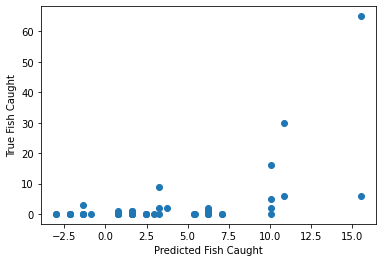

In [10]:
y_pred = np.matmul(Xte,w)
y_pred = np.squeeze(np.asarray(y_pred))

plt.scatter([y_pred], [yte])
plt.xlabel('Predicted Fish Caught')
plt.ylabel('True Fish Caught')


MSE = np.mean(np.square((y_pred.flatten() - yte.flatten()))) # The MSE
MSE

b) Repeat a) but this time with `LinearRegression` from `sklearn.linear_model`

In [11]:
from sklearn.linear_model import LinearRegression
model_skl = LinearRegression(fit_intercept=False) #We have an extended X
model_skl.fit(Xt,yt)
model_skl.coef_

array([[ 2.4822138 ,  2.95430727,  4.64953914, -5.47160051, -8.49222821]])

73.75591483452075

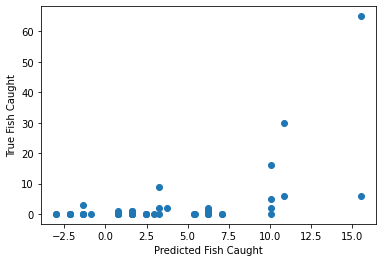

In [12]:
y_pred = np.matmul(Xte,model_skl.coef_.T)
plt.scatter([y_pred], [yte])
plt.xlabel('Predicted Fish Caught')
plt.ylabel('True Fish Caught')

np.mean(np.square((y_pred.flatten() - yte.flatten()))) # The MSE

Result: array([-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051])
Don't forget the intercept, you should have 5 numbers!

c) Determine the Root Mean Square Error (RMSE) and the average negative log-likelihood (NLL) on the testset. For NLL we assume that the conditional probability distrubution (CPD) $p(y|x)$ is given by the density of a Gaussian with constant variance $\sigma^2$. Estimate $\sigma^2$ using the variance of the residuals. Use the variance estimation with $1/N$. 

Result: $ RMSE \approx 8.58812$, $\hat \sigma^2 \approx 73.7559$, $\tt{NLL} \approx 3.569$

In [13]:
print("RMSE:", np.sqrt(MSE))
#print("SIGMA^2:", np.mean((y_pred - yte)**2))
#print("SIGMA^2:", np.mean(np.square((y_pred - yte))))
print("SIGMA^2:", MSE)
print("NLL:",0.5*np.log(2 * np.pi * MSE) + 0.5*np.mean((yte - np.squeeze(np.asarray(y_pred)))**2)/MSE)


RMSE: 8.588126386734231
SIGMA^2: 73.75591483452075
NLL: 3.5693191297796893


d) For the testset: plot the predicted mean number of fish caught ($\mu$) against observed number of fish caught. Further include the 2.5 and 97.5 precentile of p(y|x), the conditional predictive distribution (CPD) of $y$ for a given $x$. Why is a Gaussian not ideal for that kind of data? 

Hint: For the Gaussian the 2.5% and the 97.5% percentile is approximatiy given by $\mu \pm 1.96*\sigma$

In [14]:
y_pred = np.squeeze(np.asarray(y_pred))
sigma_hat_2 = np.mean((yte - y_pred.flatten())**2)

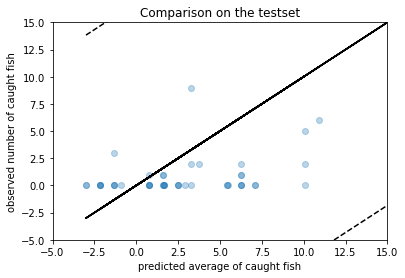

In [15]:
plt.scatter(y_pred, yte, alpha=0.3)
sort_idx=np.argsort(y_pred,axis=0)
plt.plot(y_pred[sort_idx].flatten(), y_pred[sort_idx].flatten()+1.96*np.sqrt(sigma_hat_2),linestyle='dashed',c="black")
plt.plot(y_pred[sort_idx].flatten(), y_pred[sort_idx].flatten()-1.96*np.sqrt(sigma_hat_2),linestyle='dashed',c="black")
plt.plot(y_pred, y_pred, c="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.xlim(-5,15)
plt.ylim(-5,15)
plt.show()

Text(0, 0.5, 'Observed Fish percentiles and mean')

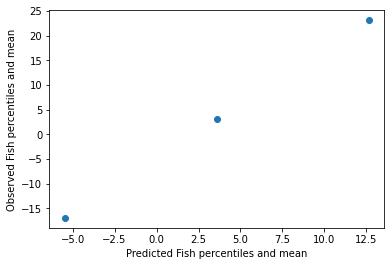

In [16]:
#df = pd.DataFrame(data = y_pred, columns = ["y_pred"])

#df.insert(loc = 1, column = "y_te", value = yte)

#display(df.head())
#display(df.describe(percentiles=[0.025, .25, .5, .75, 0.975]))

def percentile(mean, sigma):
    percentile_025 = mean - 1.96 * sigma
    percentile_975 = mean + 1.96 * sigma
    return percentile_025, mean, percentile_975

y_pred_perc = percentile(np.mean(y_pred), 4.624718)
y_te_perc = percentile(np.mean(yte), 10.222845)

#y_pred_perc, y_te_perc

plt.scatter([y_pred_perc], [y_te_perc])
plt.xlabel('Predicted Fish percentiles and mean')
plt.ylabel('Observed Fish percentiles and mean')

e) This data is count data. Count data has only positive values and also the distribution is discrete. You cannot catch 0.5 fish and that the CPD has probability density > 0 on negative number of fish is wrong too. A Gaussian as a CPD is therefore not ideal. 

Now use a Poissonian as CPD. If we assume a Poissonian then the probability to catch $k$ fish is given by 
$$
  p(k) = \exp(-\mu) \frac{\mu^k}{k!}
$$

and the NLL is thus by:

$$
 log(p(k)) = -\mu  + k \cdot \log(\mu) - log(k!)
$$

with $\mu$ being the expectation. In our case the average number of fish expected.

In the case of the probabilistic interpretation of the linear regression, $y_i$ for a given $x_i$ is distributed like a Gaussian. The paramter $\mu_i$ from $N(\mu_i,\sigma^2)$ has been determined from $x_i$ via $\mu_i= \beta^T \cdot x_i$ by minimizing the NLL. 

A small additional detail: For the Poissonian case, $\mu_i$ needs to be positive. We therefore do not use $\beta^T \cdot x_i$ directly but "pipe it through" an exponential first to make it positive and thus link $\mu_i=exp(\beta^T \cdot x_i)$ to the data.

Use a gradient descent approach on the NLL to find the solution for the parameters. Calculate the RMSE and the NLL on the test set and compare with c).

Hint: On the trainingset for the parameter values (1,1,1,1,1) the NLL should be approx 1508 and the gradient (1518.61, 1403.99, 1171.02, 5701.91, 3258.7). For the NLL a good learning rate would be 0.001 and training should be done for at least 5000 epochs.

In [17]:
def NLL(y_train, Xd, w):
    mu = np.exp(np.matmul(Xd,w))
    ret = np.zeros_like(mu)
    for i in range(ret.shape[0]):
        ret[i] = mu[i] - y_train[i]*np.log(mu[i]) + np.log(1.0*np.math.factorial(y_train[i]))
    return np.mean(ret)

w = np.ones(5)
yt_arr = np.squeeze(np.asarray(yt))
yt_arr = yt_arr.astype(int)
Xt_arr = np.squeeze(np.asarray(Xt))

NLL(yt_arr, Xt_arr, w)

1507.9856602262082

In [18]:
def gradNLL(y_train, Xd, w):
    mu = np.exp(np.matmul(Xd,w))
    #print(mu.shape)
    ret = np.zeros_like(Xd)
    for i in range(Xd.shape[0]):
        mux = Xd[i] * mu[i]
        ret[i] = -mux + y_train[i] *Xd[i]
    return np.mean(ret, axis=0)

print(NLL(yt_arr, Xt_arr,np.ones(5)))
print(np.round(gradNLL(yt_arr, Xt_arr,np.ones(5)),2))

1507.9856602262082
[-1403.99 -1171.02 -5701.91 -3258.7  -1518.61]


In [19]:
from tqdm import tqdm 
w = np.ones(5)
hist = []
for i in tqdm(range(10000)):
    if (i % 10 == 0):
        hist.append(NLL(yt_arr, Xt_arr,w))
    w = w + 0.001 * gradNLL(yt_arr, Xt_arr,w)
w, NLL(yt_arr, Xt_arr,w)

100%|██████████| 10000/10000 [00:17<00:00, 558.45it/s]


(array([ 0.56500613,  0.66091814,  0.93220074, -1.62023821, -1.74007527]),
 3.3806067025761606)

(0.0, 5.0)

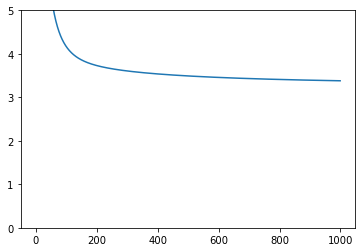

In [20]:
plt.plot(hist)
plt.ylim(0,5)

In [21]:
y_pred_poi = np.matmul(Xte, w)

y_pred_poi.shape
#yte.shape

MSE_poi = np.mean(np.square((y_pred_poi.flatten() - yte.flatten())))

print("RMSE:", np.sqrt(MSE_poi))

print("RMSE old:", np.sqrt(MSE))

RMSE: 9.935108437810758
RMSE old: 8.588126386734231


f) Do the same plot as in d) but this time with a Poisson CPD. Hint you can use scipy.stats.poisson to calculate the percentiles.

(0.0, 3.06, 7.0)
(0.0, 0.4650409507886523, 2.0)


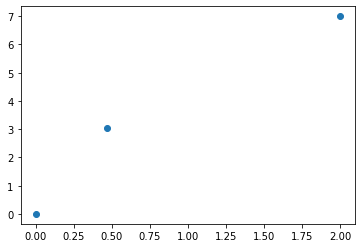

In [22]:
from scipy.stats import poisson

def poisson_perc(y):
    mu = np.mean(y)
    perc_025 = poisson.ppf(0.025, mu)
    perc_975 = poisson.ppf(0.975, mu)
    return perc_025, mu, perc_975

perc_yte_poi = poisson_perc(yte)
perc_y_pred_poi = poisson_perc(y_pred_poi)

print(perc_yte_poi)
print(perc_y_pred_poi)

plt.scatter(perc_y_pred_poi, perc_yte_poi)

(0.0, 5.0)

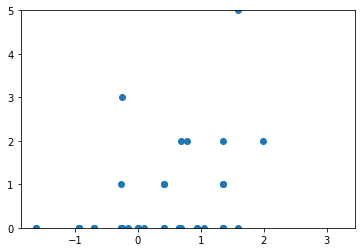

In [23]:
y_pred_poi_arr = np.squeeze(np.asarray(y_pred_poi))
sigma_hat_2_poi = np.mean((yte - y_pred_poi_arr.flatten())**2)

plt.scatter(y_pred_poi_arr, yte)
plt.ylim(0,5)

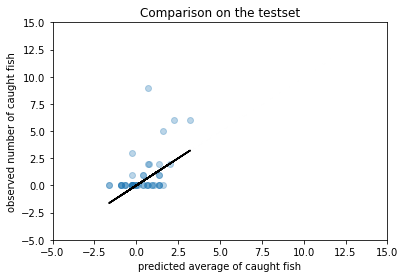

In [24]:
plt.scatter(y_pred_poi_arr, yte, alpha=0.3)
sort_idx=np.argsort(y_pred_poi_arr,axis=0)
plt.plot(y_pred_poi_arr[sort_idx].flatten(), y_pred_poi_arr[sort_idx].flatten()+1.96*np.sqrt(sigma_hat_2_poi),linestyle='dashed',c="black")
plt.plot(y_pred_poi_arr[sort_idx].flatten(), y_pred_poi_arr[sort_idx].flatten()-1.96*np.sqrt(sigma_hat_2_poi),linestyle='dashed',c="black")
plt.plot(y_pred_poi_arr, y_pred_poi_arr, c="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.xlim(-5,15)
plt.ylim(-5,15)
plt.show()